# Initialization

**Before running the code**

 - Add the shared folder to the drive shortcuts, so it will be visible when the mount is performed
 - Remember to change the paths and add dataset files if running the code in different drive folder

In [3]:
# Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
folder_name = "230487NLU_Final"
path = "/content/drive/MyDrive/" + folder_name

In [5]:
# Import 
import torch
from torch import nn
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import Parameter

from functools import wraps
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

In [6]:
# Set seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [7]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DATASET and DATALOADERS

In [33]:
# Read the txt files
def read_corpus(corpus_file, fs=" "):
    corpus = []  # list of sentences
    sents = []   # sentences list with words

    for line in open(corpus_file):
        if len(line.strip()) > 0:
            sents = list(line.strip().split(fs))
        corpus.append(sents)
        sents = []
    return corpus

# Return the vocabulary, all distinct words of the corpus
def voc(dataset):
    vocab = set()
    for sent in dataset:
      for word in sent:
        vocab.add(word)
    return vocab

In [38]:
# Path of the datasets
train_path = path + "/PennTreebankDataset/ptb.train.txt"
valid_path = path + "/PennTreebankDataset/ptb.valid.txt"
test_path = path + "/PennTreebankDataset/ptb.test.txt"

dataset_train = read_corpus(train_path)
dataset_valid = read_corpus(valid_path)
dataset_test = read_corpus(test_path)

In [10]:
# Uncomment to create a new vocabulary, otherwise the vocabulary will be loaded from folder
# Having the same vocabulary is needed to reload the model and having the same performance
''' 
# Create vocabulary on Train
vocab = voc(dataset_train)

# Dictionary that maps integers to words
int2word = dict(enumerate(vocab))

# Dictionary that maps words to integers
word2int = {word: ind for ind, word in int2word.items()}
'''

' \n# Create vocabulary on Train\nvocab = voc(dataset_train)\n\n# Dictionary that maps integers to words\nint2word = dict(enumerate(vocab))\n\n# Dictionary that maps words to integers\nword2int = {word: ind for ind, word in int2word.items()}\n'

In [11]:
'''
# Save vocabulary on txt file
path_voc = str(path + '/voc_mapping.txt')
with open (path, 'a') as f:
  for key in int2word.keys():
    s = str(int2word.get(key))
    f.write(s)
    f.write("\n")
'''

'\n# Save vocabulary on txt file\npath = str(path + \'/voc_mapping.txt\')\nwith open (path, \'a\') as f:\n  for key in int2word.keys():\n    s = str(int2word.get(key))\n    f.write(s)\n    f.write("\n")\n'

In [40]:
# Load vocabulary from txt file
path_voc = str(path + '/voc_mapping.txt')
file = open(path_voc, 'r')
lines = file.readlines()
int2word = {}
for i, line in enumerate(lines):
    val = str(line.strip())
    int2word[i] = val

# Dictionary that maps words to integers
word2int = {word: ind for ind, word in int2word.items()}

In [41]:
class MyDataset (data.Dataset):
    def __init__(self, dataset, unk='unk'):
        self.words = []
    
        for sent in dataset:
          words_sent = []
          for word in sent:
            words_sent.append(word)
          self.words.append(words_sent)

        self.word_ids = self.mapping_seq(self.words)

    def __len__(self):
        return len(self.words)

    def __getitem__(self, idx):
        word_id = torch.Tensor(self.word_ids[idx])
        return word_id
        
    # Auxiliary methods
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]

    # Map sequences to number
    def mapping_seq(self, data): 
        ids = []
        for sent in data:
            sent_ids = []
            for word in sent:
                id = word2int.get(word)
                if id == None:
                    id = 0 
                sent_ids.append(id)
            ids.append(sent_ids)
            
        return ids

In [42]:
def collate_fn(data):
    #merge from batch * sent_len to batch * max_len 
    def merge(sequences):
        lengths = []
        for seq in sequences:
          length = len(seq) - 1
          if length > 0:
            lengths.append(length)
          else:
            lengths.append(1)

        max_len = 1 if max(lengths)==0 else max(lengths)

        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)

        for i, seq in enumerate(sequences):
            end = lengths[i] #we leave out last word
            padded_seqs[i, :end] = seq[0:end] # We copy each sequence into the tensor
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        
        target_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        
        for i, seq in enumerate(sequences):
            end = lengths[i]
            if end == 1:
              end = len(seq) -1
            target_seqs[i, :end] = seq[1: end + 1] # We copy each sequence into the matrix, we leave out first word
        target_seqs = target_seqs.detach() # We remove these tensors from the computational graph

        return padded_seqs, lengths, target_seqs

    # Sort data by seq lengths
    data.sort(key=lambda x: len(x), reverse=True)
    new_item = {}

    src, lengths, target = merge(data)
    src = src.to(device) 
    target = target.to(device)

    new_item["words"] = src
    new_item["target"] = target
    new_item["lengths"] = lengths
    
    return new_item

In [43]:
# DataLoader
PAD_TOKEN = 0

dataset_train = MyDataset(dataset_train)
dataset_valid = MyDataset(dataset_valid)
dataset_test = MyDataset(dataset_test)

train_loader = DataLoader(dataset_train, batch_size=128, collate_fn=collate_fn,  shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=128, collate_fn=collate_fn,  shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=128, collate_fn=collate_fn,  shuffle=True)

# Vanilla RNN and LSTM

## Init Weights, Train and Eval Loop


In [16]:
# Initialize Weights
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [17]:
# Train loop
def train_loop(data, optimizer, criterion, model):
    model.train()
    loss_array = []
    perplexity_array = []
    for sample in data:
      
        optimizer.zero_grad() # Zeroing the gradient
        output, hidden = model(sample['words'], sample['lengths'])
        
        loss = criterion(output, sample['target'])
        loss_array.append(loss.item())

        perplexity = torch.exp(loss)
        perplexity_array.append(perplexity.item())
        loss.backward() # Compute the gradient
        optimizer.step() # Update the weights
    return loss_array, perplexity_array
     

In [18]:
# Evaluation loop
def eval_loop(data, criterion, model):
  model.eval()
  loss_array = []
  perplexity_array = []
  
  with torch.no_grad():
      for sample in data:

            output, hidden = model(sample['words'], sample['lengths'])
            loss = criterion(output, sample['target'])
            perplexity = torch.exp(loss)

            loss_array.append(loss.item())
            perplexity_array.append(perplexity.item())

  return loss_array, perplexity_array

## Vanilla RNN

In [19]:
class RNN(nn.Module):
  def __init__(self, hidden_size, output_size, emb_size, vocab_len, n_layers = 1, pad_index = 0):
   
        super(RNN, self).__init__()

        # Defining parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Defining the layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx= pad_index)
        # RNN Layer
        self.rnn = nn.RNN(emb_size, hidden_size, n_layers)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)


  def forward(self, x, seq_lengths):
        emb = self.embedding(x) #emb.size() = batch_size x seq len x emb size
        emb = emb.permute(1,0,2) # we need seq len first --> seq len x batch size x emb size
        
        # Packed input
        packed_input = pack_padded_sequence(emb, seq_lengths, enforce_sorted=False)
        
        # Initializing hidden state for first input
        hidden = self.init_hidden(128)
        
        # Output
        packed_output, hidden = self.rnn(packed_input, hidden)
        
        # Unpack the sequence
        words_encoded, input_sizes = pad_packed_sequence(packed_output)

        # Get the last hidden state
        hidden = hidden[-1,:,:]
        
        output = self.fc(words_encoded)
        output = output.permute(1,2,0)

        return output, hidden

  def init_hidden(self, batch_size):
        # Generation of the first hidden state used in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        hidden = hidden.to(device)
        return hidden

In [20]:
# Define hyperparameters
n_epochs = 5
lr=0.01
hidden_size = 100
voc_size = 9999
emb_size = 200

# Net
model = RNN(hidden_size, voc_size, emb_size, voc_size).to(device)
model.apply(init_weights)

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
losses_train = []
train_perplexity = []

losses_valid = []
valid_perplexity = []

sampled_epochs = []

for x in tqdm(range(1,n_epochs)):
    loss, perplexity = train_loop(train_loader, optimizer, criterion, model)

    sampled_epochs.append(x)
    losses_train.append(np.asarray(loss).mean())
    train_perplexity.append(np.asarray(perplexity).mean())

    loss_valid, per_valid = eval_loop(valid_loader, criterion, model)
    losses_valid.append(np.asarray(loss_valid).mean())
    valid_perplexity.append(np.asarray(per_valid).mean())

_, test_perplexity = eval_loop(test_loader, criterion, model)
test_perplexity_mean = np.asarray(test_perplexity).mean()

print("loss train:", losses_train)
print("per train:", train_perplexity)

print("loss valid:", losses_valid)
print("per valid:", valid_perplexity)

print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

100%|██████████| 4/4 [01:30<00:00, 22.59s/it]


loss train: [5.890780031499892, 5.2077453317613225, 4.990073472170844, 4.86535610471453]
per train: [487.4610595239332, 183.5986353169821, 147.76238691335755, 130.77897528094724]
loss valid: [5.4936674082720724, 5.424387984805637, 5.446660377361156, 5.483498167108606]
per valid: [244.55253092447916, 228.89852509675202, 233.8851510507089, 242.25565875018086]
test perplexity [223.6893768310547, 260.29998779296875, 214.19956970214844, 207.14703369140625, 218.86058044433594, 227.28509521484375, 226.7731475830078, 211.99560546875, 223.7060089111328, 237.21490478515625, 215.87655639648438, 193.6989288330078, 234.64295959472656, 239.33636474609375, 200.83746337890625, 191.223388671875, 197.44293212890625, 228.03848266601562, 197.92262268066406, 194.11361694335938, 236.4768524169922, 225.0504608154297, 225.6262664794922, 231.70269775390625, 207.89959716796875, 236.2871551513672, 199.5345916748047, 196.71434020996094, 211.4391326904297, 197.4762420654297]
test perplexity mean 217.08373209635417

## LSTM

In [22]:
class LSTM(nn.Module):
  def __init__(self, hidden_size, output_size, emb_size, vocab_len, n_layers = 1, pad_index = 0):
   
        super(LSTM, self).__init__()

        # Defining some parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Defining the layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx= pad_index)
        # RNN Layer
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, bidirectional=False)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, seq_lengths):

        emb = self.embedding(x) #emb.size() = batch_size x seq len x emb size
        emb = emb.permute(1,0,2) # we need seq len first --> seq len x batch size x emb size

        #packed input
        packed_input = pack_padded_sequence(emb, seq_lengths, enforce_sorted=False)

        # Initializing hidden state for first input
        hidden = self.init_hidden(128)

        # Outputs
        packed_output, (last_hidden, cell) = self.lstm(packed_input)
        
        # Unpack the sequence
        words_encoded, input_sizes = pad_packed_sequence(packed_output)
 
        # Get the last hidden state
        hidden = hidden[-1,:,:]
        
        output = self.fc(words_encoded)
        output = output.permute(1,2,0)

        return output, hidden

  def init_hidden(self, batch_size):
        # Generation of the first hidden state used in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        hidden = hidden.to(device)
        return hidden

In [23]:
# Define hyperparameters
lr=0.01
hidden_size = 200
voc_size = 9999
emb_size = 200

# Net
model = LSTM(hidden_size, voc_size, emb_size, voc_size).to(device)
model.apply(init_weights)

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
n_epochs = 5
losses_train = []
train_perplexity = []

losses_valid = []
valid_perplexity = []

sampled_epochs = []

for x in tqdm(range(1,n_epochs)):
    loss, perplexity = train_loop(train_loader, optimizer, criterion, model)


    sampled_epochs.append(x)
    losses_train.append(np.asarray(loss).mean())
    train_perplexity.append(np.asarray(perplexity).mean())

    loss_valid, per_valid = eval_loop(valid_loader, criterion, model)
    losses_valid.append(np.asarray(loss_valid).mean())
    valid_perplexity.append(np.asarray(per_valid).mean())

_, test_perplexity = eval_loop(test_loader, criterion, model)
test_perplexity_mean = np.asarray(test_perplexity).mean()


print("loss train:", losses_train)
print("per train:", train_perplexity)

print("loss valid:", losses_valid)
print("per valid:", valid_perplexity)

print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

100%|██████████| 4/4 [01:46<00:00, 26.73s/it]


loss train: [5.684772504499255, 4.887702438969018, 4.563207840847027, 4.340884476809516]
per train: [404.60126108094187, 133.29146953919013, 96.46481940086852, 77.32636888266335]
loss valid: [5.270175774892171, 5.164917928201181, 5.167466887721309, 5.219149342289677]
per valid: [195.80424612539787, 176.43751469364872, 176.86423972800927, 186.23173240379052]
test perplexity [185.26707458496094, 206.26901245117188, 161.5718536376953, 152.36318969726562, 179.17117309570312, 173.95079040527344, 169.20663452148438, 145.4995574951172, 138.54473876953125, 153.9076385498047, 187.43771362304688, 139.9885711669922, 211.08181762695312, 186.81642150878906, 188.3022003173828, 159.2921142578125, 172.74876403808594, 162.2530517578125, 153.53504943847656, 149.7451629638672, 168.91441345214844, 167.94590759277344, 179.36041259765625, 190.63070678710938, 186.1365509033203, 190.1033172607422, 162.7132568359375, 161.96563720703125, 163.13043212890625, 177.25880432128906]
test perplexity mean 170.837065633

# LSTM with Regularization Techniques


In [25]:
# Save current weights of the NN and the optimizer
def save_model(epoch, model, optimizer, loss, path, name):
  
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                  }, f'{path}/{name}.tar')

In [26]:
# Code taken by https://github.com/salesforce/awd-lstm-lm
class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
        # It must be a function rather than a lambda as otherwise pickling explodes
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = mask.expand_as(raw_w) * raw_w
            else:
                w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [27]:
class MyLSTM(nn.Module):
  def __init__(self, hidden_size, output_size, emb_size, vocab_len, n_layers = 1, pad_index = 0):
   
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Defining the layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx= pad_index)
        # LSTM Layer
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, bidirectional=False)
        WeightDrop(torch.nn.LSTM(10, 10), ['weight_hh_l0'], dropout=0.9)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, seq_lengths):

        emb = self.embedding(x) #emb.size() = batch_size x seq len x emb size
        emb = emb.permute(1,0,2) # we need seq len first --> seq len x batch size x emb size

        #packed input
        packed_input = pack_padded_sequence(emb, seq_lengths, enforce_sorted=False)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(128)

        # Output
        packed_output, (last_hidden, cell) = self.lstm(packed_input)
        
        # Unpack the sequence
        words_encoded, input_sizes = pad_packed_sequence(packed_output)

        # Get the last hidden state
        hidden = hidden[-1,:,:]
        
        output = self.fc(words_encoded)
        output = output.permute(1,2,0)

        return output, hidden

  def init_hidden(self, batch_size):
        # Generation of the first hidden state used in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        hidden = hidden.to(device)
        return hidden

In [28]:
# Initialize Weights
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

In [29]:
# Train Loop
def train_loop(data, optimizer, criterion, model):
    model.train()

    loss_array = []
    perplexity_array = []
    for sample in data:
      
        optimizer.zero_grad() # Zeroing the gradient
    
        output, hidden = model(sample['words'], sample['lengths'])
        loss = criterion(output, sample['target'])
  
        loss_array.append(loss.item())

        perplexity = torch.exp(loss)
        perplexity_array.append(perplexity.item())
        loss.backward() # Compute the gradient

        # Clip the gradient to avoid explosioning gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) 

        # Update the weights
        optimizer.step() 

    return loss_array, perplexity_array

In [30]:
# Eval Loop
def eval_loop(data, criterion, model):
  model.eval()
  loss_array = []
  perplexity_array = []

  with torch.no_grad():
      for sample in data:
            output, hidden = model(sample['words'], sample['lengths'])
            loss = criterion(output, sample['target'])

            perplexity = torch.exp(loss)

            loss_array.append(loss.item())
            perplexity_array.append(perplexity.item())

  return loss_array, perplexity_array

In [36]:
# Define hyperparameters
lr=0.01
wd = 0.00001
hidden_size = 200
voc_size = 9999
emb_size = 200
output_size = 9999
n_layers = 3
n_epochs = 40

# Parameters for saving the model
save_path = path + "/Models/"
save_name = "LSTMreg"
min_per = 110 # minimum perplexity on val set to save the model

# Net
model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)
model.apply(init_weights)

# Define Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, threshold = 0.01)

Applying weight drop of 0.9 to weight_hh_l0


In [37]:
losses_train = []
train_perplexity = []

losses_valid = []
valid_perplexity = []

sampled_epochs = []

for x in tqdm(range(0,n_epochs)):
    loss, perplexity = train_loop(train_loader, optimizer, criterion, model)

    sampled_epochs.append(x)
    losses_train.append(np.asarray(loss).mean())
    train_perplexity.append(np.asarray(perplexity).mean())
    print("per train:", np.asarray(perplexity).mean())

    loss_valid, per_valid = eval_loop(valid_loader, criterion, model)
    
    losses_valid.append(np.asarray(loss_valid).mean())
    val_per = np.asarray(per_valid).mean()
    valid_perplexity.append(val_per)
    print("per val:", val_per)

    # save model if perplexity on val is less than a certain value
    if save_path is not None and (val_per < min_per):
      min_per = val_per
      print(f"Saving model at {save_path}/{save_name}")
      save_model(x, model, optimizer, np.asarray(loss).mean(),  path= save_path, name=f"{save_name}[{min_per}]")

    scheduler.step(np.asarray(loss_valid).mean())

_, test_perplexity = eval_loop(test_loader, criterion, model)  
test_perplexity_mean = np.asarray(test_perplexity).mean()

print("per train:", train_perplexity)
print("per valid:", valid_perplexity)

print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

  0%|          | 0/40 [00:00<?, ?it/s]

per train: 816.690536267127


  2%|▎         | 1/40 [00:30<19:36, 30.16s/it]

per val: 301.27499615704573
per train: 223.77125544678478


  5%|▌         | 2/40 [00:59<18:40, 29.49s/it]

per val: 192.82049221462674
per train: 160.8500089790321


  8%|▊         | 3/40 [01:28<18:04, 29.32s/it]

per val: 160.10871152524595
per train: 135.3287015874335


 10%|█         | 4/40 [01:58<17:45, 29.60s/it]

per val: 147.2132031476056
per train: 120.781207910787


 12%|█▎        | 5/40 [02:27<17:10, 29.45s/it]

per val: 138.34888797336154
per train: 110.82900537183582


 15%|█▌        | 6/40 [02:56<16:40, 29.43s/it]

per val: 132.91475197120948
per train: 103.90046040265393


 18%|█▊        | 7/40 [03:26<16:12, 29.48s/it]

per val: 129.6951816700123
per train: 98.38848132565391


 20%|██        | 8/40 [03:56<15:44, 29.52s/it]

per val: 127.55806619149668
per train: 94.12722880354768


 22%|██▎       | 9/40 [04:25<15:13, 29.45s/it]

per val: 124.71869772451895
per train: 90.53809625689382


 25%|██▌       | 10/40 [04:54<14:41, 29.39s/it]

per val: 122.62485278094256
per train: 87.69557904182597


 28%|██▊       | 11/40 [05:23<14:10, 29.31s/it]

per val: 121.61625106246383
per train: 85.33077544934119


 30%|███       | 12/40 [05:53<13:41, 29.35s/it]

per val: 122.13353305392795
per train: 83.11238256993627


 32%|███▎      | 13/40 [06:22<13:12, 29.36s/it]

per val: 119.95700864438658
per train: 81.42212802226058


 35%|███▌      | 14/40 [06:51<12:42, 29.34s/it]

per val: 120.26124487982855
per train: 79.64095086094818


 38%|███▊      | 15/40 [07:20<12:11, 29.27s/it]

per val: 119.1779443246347
per train: 77.88904842852097


 40%|████      | 16/40 [07:50<11:43, 29.31s/it]

per val: 118.5696880199291
per train: 55.348465719483904


 42%|████▎     | 17/40 [08:19<11:15, 29.37s/it]

per val: 106.74351586235895
Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg
per train: 48.73343689753292


 45%|████▌     | 18/40 [08:49<10:45, 29.33s/it]

per val: 107.28583696153429
per train: 45.470597890372694


 48%|████▊     | 19/40 [09:18<10:14, 29.27s/it]

per val: 108.64079341182003
per train: 42.98249194252455


 50%|█████     | 20/40 [09:47<09:45, 29.28s/it]

per val: 109.95777469211154
per train: 40.69552111408269


 52%|█████▎    | 21/40 [10:16<09:15, 29.22s/it]

per val: 111.98384433322482
per train: 38.42547474081393


 55%|█████▌    | 22/40 [10:45<08:44, 29.14s/it]

per val: 113.45077232078269
per train: 36.210392896889914


 57%|█████▊    | 23/40 [11:14<08:14, 29.08s/it]

per val: 117.40900166829427
per train: 31.402450520941553


 60%|██████    | 24/40 [11:44<07:47, 29.22s/it]

per val: 119.85526219120732
per train: 30.775014541069424


 62%|██████▎   | 25/40 [12:13<07:18, 29.21s/it]

per val: 120.26556424741392
per train: 30.367517239416987


 65%|██████▌   | 26/40 [12:42<06:49, 29.28s/it]

per val: 121.30874181676793
per train: 30.03300487089302


 68%|██████▊   | 27/40 [13:11<06:20, 29.27s/it]

per val: 121.78942277696397
per train: 29.748234044454744


 70%|███████   | 28/40 [13:41<05:52, 29.35s/it]

per val: 123.04718102349176
per train: 29.485198823876658


 72%|███████▎  | 29/40 [14:10<05:23, 29.38s/it]

per val: 123.27016590259693
per train: 28.966890729307043


 75%|███████▌  | 30/40 [14:40<04:53, 29.38s/it]

per val: 122.59324928566262
per train: 28.925905233458543


 78%|███████▊  | 31/40 [15:09<04:24, 29.42s/it]

per val: 124.15621524386935
per train: 28.90321960565167


 80%|████████  | 32/40 [15:40<03:57, 29.66s/it]

per val: 125.6812806306062
per train: 28.88022645411158


 82%|████████▎ | 33/40 [16:09<03:27, 29.60s/it]

per val: 124.7270366527416
per train: 28.86119699333214


 85%|████████▌ | 34/40 [16:38<02:57, 29.55s/it]

per val: 123.52439202202692
per train: 28.820144641725488


 88%|████████▊ | 35/40 [17:08<02:27, 29.47s/it]

per val: 123.69069417317708
per train: 28.756346554741672


 90%|█████████ | 36/40 [17:37<01:58, 29.53s/it]

per val: 125.54877443666811
per train: 28.774350627215075


 92%|█████████▎| 37/40 [18:07<01:28, 29.54s/it]

per val: 125.05791784215856
per train: 28.755001015938525


 95%|█████████▌| 38/40 [18:36<00:59, 29.51s/it]

per val: 123.819620485659
per train: 28.75459327233961


 98%|█████████▊| 39/40 [19:06<00:29, 29.41s/it]

per val: 124.34648951777706
per train: 28.754929835310822


100%|██████████| 40/40 [19:35<00:00, 29.38s/it]

per val: 124.74548283329716


per train: [816.690536267127, 223.77125544678478, 160.8500089790321, 135.3287015874335, 120.781207910787, 110.82900537183582, 103.90046040265393, 98.38848132565391, 94.12722880354768, 90.53809625689382, 87.69557904182597, 85.33077544934119, 83.11238256993627, 81.42212802226058, 79.64095086094818, 77.88904842852097, 55.348465719483904, 48.73343689753292, 45.470597890372694, 42.98249194252455, 40.69552111408269, 38.42547474081393, 36.210392896889914, 31.402450520941553, 30.775014541069424, 30.367517239416987, 30.03300487089302, 29.748234044454744, 29.485198823876658, 28.966890729307043, 28.925905233458543, 28.90321960565167, 28.88022645411158, 28.86119699333214, 28.820144641725488, 28.756346554741672, 28.774350627215075, 28.755001015938525, 28.75459327233961, 28.754929835310822]
per valid: [301.27499615704573, 192.82049221462674, 160.10871152524595, 147.2132031476056, 138.34888797336154, 132.91475197120948, 129.6951816700123, 127.55806619149668, 124.71869772451895, 122.62485278094256, 12

In [44]:
# Early stopping performance
lr=0.01
wd = 0.00001
hidden_size = 200
voc_size = 9999
emb_size = 200
output_size = 9999
n_layers = 3

model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, threshold = 0.01)

# Load the net
checkpoint = torch.load(path + "/Models/LSTMreg[106.74351586235895].tar")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

_, test_perplexity = eval_loop(test_loader, criterion, model)  
test_perplexity_mean = np.asarray(test_perplexity).mean()

print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

Applying weight drop of 0.9 to weight_hh_l0
test perplexity [101.42798614501953, 96.22144317626953, 106.48209381103516, 135.02755737304688, 115.1781997680664, 88.35993194580078, 92.1584701538086, 90.45838928222656, 124.86495971679688, 102.90897369384766, 110.62401580810547, 102.4731674194336, 106.76533508300781, 107.87232208251953, 107.4656982421875, 114.24101257324219, 74.56851959228516, 97.54131317138672, 98.28186798095703, 109.73937225341797, 116.93950653076172, 119.85132598876953, 104.6828842163086, 99.80941009521484, 94.3652114868164, 105.35350799560547, 89.24513244628906, 89.83694458007812, 107.8995361328125, 99.43470001220703]
test perplexity mean 103.66929295857747


# Multiple Runs
To ensure the performance is constant across multiple trials

In [55]:
# Define hyperparameters
lr=0.01
wd = 0.00001
hidden_size = 200
voc_size = 9999
emb_size = 200
output_size = 9999
n_layers = 3

# Parameters for saving the model
save_path = path + "/Models/"
save_name = "LSTMreg"
min_per = 115

In [57]:
runs = 5
m_pre_train, m_pre_test = [], []

# Initialize and train n models
for run in tqdm(range(0, runs)):
    model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)
    model.apply(init_weights)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, threshold = 0.01)

    n_epochs = 35
    min_per = 110
    losses_train = []
    train_perplexity = []

    losses_valid = []
    valid_perplexity = []

    sampled_epochs = []
  
    for x in tqdm(range(0,n_epochs)):
        loss, perplexity = train_loop(train_loader, optimizer, criterion, model)

        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        train_perplexity.append(np.asarray(perplexity).mean())
        loss_valid, per_valid = eval_loop(valid_loader, criterion, model)

        losses_valid.append(np.asarray(loss_valid).mean())
        val_per = np.asarray(per_valid).mean()
        valid_perplexity.append(val_per)

        if save_path is not None and (val_per < min_per):
          min_per = val_per
          print(f"Saving model at {save_path}/{save_name}")
          save_model(x, model, optimizer, np.asarray(loss).mean(), path= save_path, name=f"{run}[{save_name}]")

        scheduler.step(np.asarray(loss_valid).mean())

    _, test_perplexity = eval_loop(test_loader, criterion, model)  
    test_perplexity_mean = np.asarray(test_perplexity).mean()

    m_pre_train.append(train_perplexity)
    m_pre_test.append(test_perplexity_mean)

# Perplexity test and mean for both train and test with the model at the end of the training
print(m_pre_test)
m_pre_train = np.asarray(m_pre_train)
m_pre_test = np.asarray(m_pre_test)
print('Perplexity Train', round(m_pre_train.mean(),3), '+-', round(m_pre_train.std(),3))
print('Perplexity Test', round(m_pre_test.mean(), 3), '+-', round(m_pre_test.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

Applying weight drop of 0.9 to weight_hh_l0



 54%|█████▍    | 19/35 [09:18<07:48, 29.31s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 60%|██████    | 21/35 [10:17<06:53, 29.55s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 20%|██        | 1/5 [17:08<1:08:34, 1028.58s/it]

Applying weight drop of 0.9 to weight_hh_l0



 49%|████▊     | 17/35 [08:16<08:43, 29.11s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 40%|████      | 2/5 [34:12<51:18, 1026.05s/it]  

Applying weight drop of 0.9 to weight_hh_l0



 46%|████▌     | 16/35 [07:47<09:14, 29.21s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 60%|██████    | 3/5 [51:17<34:10, 1025.32s/it]

Applying weight drop of 0.9 to weight_hh_l0



 57%|█████▋    | 20/35 [09:44<07:18, 29.20s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 80%|████████  | 4/5 [1:08:21<17:05, 1025.03s/it]

Applying weight drop of 0.9 to weight_hh_l0



 49%|████▊     | 17/35 [08:16<08:46, 29.25s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



 54%|█████▍    | 19/35 [09:16<07:51, 29.44s/it]

Saving model at /content/drive/MyDrive/230487NLU_Final/Models//LSTMreg



100%|██████████| 5/5 [1:25:26<00:00, 1025.23s/it]

[118.54697875976562, 120.31168721516927, 120.0705327351888, 124.42008438110352, 118.9578643798828]
Perplexity Train 90.641 +- 128.265
Perplexity Test 120.461 +- 2.087


In [58]:
# Early stopped versions of the n nets
m_pre_test = []
for run in tqdm(range(0, runs)):
    model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)

    # load model
    checkpoint = torch.load(path + "/Models/" + str(run) + "[LSTMreg].tar")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.eval()

    _, test_perplexity = eval_loop(test_loader, criterion, model)  
    test_perplexity_mean = np.asarray(test_perplexity).mean()
    m_pre_test.append(test_perplexity_mean)

print(m_pre_test)
m_pre_test = np.asarray(m_pre_test)
print('Perplexity Test', round(m_pre_test.mean(), 3), '+-', round(m_pre_test.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

Applying weight drop of 0.9 to weight_hh_l0


 20%|██        | 1/5 [00:00<00:03,  1.08it/s]

Applying weight drop of 0.9 to weight_hh_l0


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]

Applying weight drop of 0.9 to weight_hh_l0


 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

Applying weight drop of 0.9 to weight_hh_l0


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

Applying weight drop of 0.9 to weight_hh_l0


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

[102.9025286356608, 104.07815602620443, 105.98849487304688, 104.06203842163086, 104.81571502685547]
Perplexity Test 104.369 +- 1.015


# Error Analysis


## Plot Losses and Perplexity

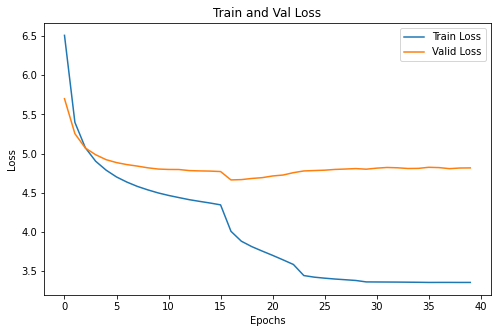

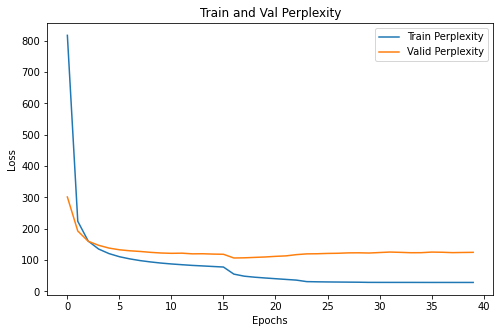

In [46]:
# Plot loss of train of valid set
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs, losses_train, label='Train Loss')
plt.plot(sampled_epochs, losses_valid, label='Valid Loss')
plt.legend()
plt.show()

# Plot perplexity of train and valid set
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Val Perplexity')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs, train_perplexity, label='Train Perplexity')
plt.plot(sampled_epochs, valid_perplexity, label='Valid Perplexity')
plt.legend()
plt.show()

## Analysis on the Sentences

In [47]:
# Evaluate Loop for Error Analysis
def eval_loop_ea(data, criterion, model, max_perplexity = 100, min_perplexity = 120):
  model.eval()
  loss_array = []
  perplexity_array = []

  with torch.no_grad(): # It used to avoid the creation of computational graph

      maxp_target_sents = []
      minp_target_sents = []
      maxp_output_sents = []
      minp_output_sents = []

      for sample in data:
            output, hidden = model(sample['words'], sample['lengths'])
            loss = criterion(output, sample['target'])

            perplexity = torch.exp(loss)
            
            loss_array.append(loss.item())
            perplexity_array.append(perplexity.item())

            # List of target and output sentences
            target_list = sample['target'].tolist()
            target_sents = []

            for sent in target_list:
              s = []
              for item in sent:
                if item != 0:
                  word = int2word.get(item)
                  s.append(word)
              target_sents.append(s)
            
            output_sents = []
            mp_output_sents = []

            for e, x in enumerate(torch.argmax(output, dim=1).tolist()):
              s = []
              for i, word in enumerate(x):
                if i < len(target_sents[e]):
                  out = int2word.get(word)
                  s.append(out)
              output_sents.append(s)

            # The worst and best perplexity sentences
            if perplexity >= max_perplexity:
                maxp_target_sents = target_sents
                maxp_output_sents = output_sents
                max_perplexity = perplexity
            elif perplexity <= min_perplexity:
                minp_target_sents = target_sents
                minp_output_sents = output_sents
                min_perplexity = perplexity
      
            
  return loss_array, perplexity_array, maxp_target_sents, maxp_output_sents, minp_target_sents, minp_output_sents

### Analysis on Sentences of the Test Set

In [48]:
# Load model

lr=0.01
wd = 0.00001
hidden_size = 200
voc_size = 9999
emb_size = 200
output_size = 9999
n_layers = 3

model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, threshold = 0.01)


checkpoint = torch.load(path + "/Models/LSTMreg[106.74351586235895].tar")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

_, test_perplexity, max_target, max_output, min_target, min_output = eval_loop_ea(test_loader, criterion, model)  
test_perplexity_mean = np.asarray(test_perplexity).mean()


print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

Applying weight drop of 0.9 to weight_hh_l0
test perplexity [107.33485412597656, 89.02963256835938, 106.8239517211914, 99.78936767578125, 90.12149810791016, 104.71025085449219, 97.75260925292969, 104.1302719116211, 119.4901123046875, 112.48188781738281, 136.0662384033203, 100.90790557861328, 97.45860290527344, 85.83504486083984, 106.44559478759766, 87.14423370361328, 89.90770721435547, 106.60702514648438, 114.29833221435547, 90.14535522460938, 114.53031921386719, 104.86214447021484, 107.34473419189453, 100.03958892822266, 113.29486083984375, 109.76632690429688, 104.62629699707031, 108.80244445800781, 103.00666809082031, 75.74971008300781]
test perplexity mean 102.95011901855469


In [49]:
# Max and Min perplexity values
max_per = max(test_perplexity)
min_per = min(test_perplexity)
print("max per: ", max_per)
print("min per: ", min_per)

# Avg sents lenght
lens_max = [len(x) for x in max_target]
avg_max = sum(lens_max) / len(lens_max)
print("average length of batch of max perplexity: ", avg_max)

lens_min = [len(x) for x in min_target]
avg_min = sum(lens_min) / len(lens_min)
print("average length of batch of min perplexity: ", avg_min)

# Example of a bad and a good sentence
print("max target: ", max_target[0])
print("max output: ", max_output[0])
print("min target: ", min_target[0])
print("min output: ", min_output[0])

max per:  136.0662384033203
min per:  75.74971008300781
average length of batch of max perplexity:  20.84375
average length of batch of min perplexity:  19.693877551020407
max target:  ["'s", 'line', 'of', '<unk>', 'for', 'example', 'features', 'the', '<unk>', 'which', 'is', 'in', 'the', 'same', 'weight', 'class', 'but', 'is', 'much', 'slower', 'and', 'has', 'less', 'memory', 'and', 'the', '<unk>', 'which', 'also', 'uses', 'a', 'N', 'microprocessor', 'but', 'which', '<unk>', 'almost', 'twice', 'as', 'much', 'and', 'is', 'three', 'times', 'the', 'size']
max output:  ['corp.', '<unk>', 'is', '<unk>', '<unk>', 'the', 'is', 'a', '<unk>', 'of', 'is', '<unk>', 'the', '<unk>', 'time', 'as', 'with', 'it', "n't", 'more', 'than', '<unk>', 'been', '<unk>', 'capacity', '<unk>', '<unk>', 'of', 'are', '<unk>', 'the', '<unk>', 'N', '<unk>', 'the', 'is', '<unk>', 'N', 'as', 'a', 'as', '<unk>', '<unk>', 'years', 'the', '<unk>']
min target:  ['N', 'N', 'to', 'N', 'N', 'N', 'one', 'month', 'N', 'N', 'N',

### Analysis on the Sentences Length-wise

In [50]:
# Some example sentences from test set
#example_sent =  "but while the new york stock exchange did n't fall apart friday as the dow jones industrial average plunged N points most of it in the final hour it barely managed to stay this side of chaos"
#example_sent = "once again the specialists were not able to handle the imbalances on the floor of the new york stock exchange said christopher <unk> senior vice president at <unk> securities corp"
#example_sent = "at this point the dow was down about N points"
example_sent = "he 's not exactly sitting pretty at this stage "
example = list(example_sent.split())

# Add one word of the time to have sentences of increased length
ex = []
for i in range(2, len(example) + 1):
  sent = example[0:i]
  ex.append(sent)
print(ex)

# Batch_size = 1 to address one sentence at the time
ex = MyDataset(ex)
sent_loader = DataLoader(ex, batch_size=1, collate_fn=collate_fn,  shuffle=False)

[['he', "'s"], ['he', "'s", 'not'], ['he', "'s", 'not', 'exactly'], ['he', "'s", 'not', 'exactly', 'sitting'], ['he', "'s", 'not', 'exactly', 'sitting', 'pretty'], ['he', "'s", 'not', 'exactly', 'sitting', 'pretty', 'at'], ['he', "'s", 'not', 'exactly', 'sitting', 'pretty', 'at', 'this'], ['he', "'s", 'not', 'exactly', 'sitting', 'pretty', 'at', 'this', 'stage']]


In [52]:
lr=0.01
wd = 0.00001
hidden_size = 200
voc_size = 9999
emb_size = 200
output_size = 9999
n_layers = 3

model = MyLSTM(hidden_size, output_size, emb_size, voc_size, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, threshold = 0.01)

checkpoint = torch.load(path + "/Models/LSTMreg[106.74351586235895].tar")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

_, test_perplexity, max_target, max_output, min_target, min_output = eval_loop_ea(sent_loader, criterion, model)  
test_perplexity_mean = np.asarray(test_perplexity).mean()

print("test perplexity", test_perplexity)
print("test perplexity mean", test_perplexity_mean)

Applying weight drop of 0.9 to weight_hh_l0
test perplexity [45.11174392700195, 24.52284812927246, 74.38633728027344, 211.00343322753906, 537.3702392578125, 574.6303100585938, 373.5033264160156, 350.73638916015625]
test perplexity mean 273.90807843208313


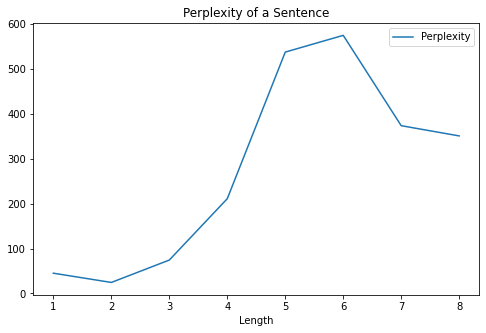

In [53]:
# Plot perplexity of the sentence of increasing length
sent_l = [i for i in range(1, len(test_perplexity) + 1)]
plt.figure(num = 1, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity of a Sentence')
plt.xlabel('Length')
plt.plot(sent_l, test_perplexity, label='Perplexity')
plt.legend()
plt.show()

In [54]:
# Sentences portions with max and min perplexity
max_per = max(test_perplexity)
max_index = test_perplexity.index(max_per)

min_per = min(test_perplexity)
min_index = test_perplexity.index(min_per)

print("max per: ", max_per, max_index - 1)
print("max target: ", max_target[0], "max output: ", max_output[0])
print("min per: ", min_per, min_index - 1)
print("min target: ", min_target[0], "min output: ", min_output[0])

max per:  574.6303100585938 4
max target:  ["'s", 'not', 'exactly', 'sitting', 'pretty', 'at'] max output:  ['said', 'a', 'a', 'a', 'in', '<unk>']
min per:  24.52284812927246 0
min target:  ["'s", 'not'] min output:  ['said', 'a']
